This notebook demonstrates the analysis of customers of Bank Indessa. The purpose of this exercise is to help Bank Indessa predict frauds, when they come across new customers. There are some cases where there is a stark difference between fraud customers and non-fraud customers for Bank Indessa. The data is cleaned and preprocessed for Exploratory Data Analysis. After analysis is done, Machine Learning Algorithms are used to predict fraud in the hold out sample.


# Importing Libraries

In [302]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel


# Reading the data(training)

In [303]:
data = pd.read_csv('train_indessa.csv')

In [304]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,...,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,...,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,...,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,...,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,...,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,...,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


# Class Distribution

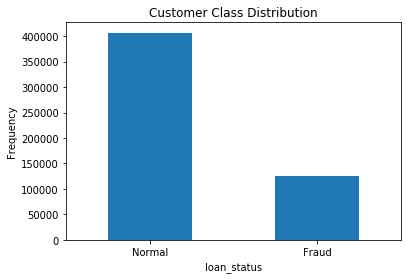

In [305]:
LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(data['loan_status'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Customer Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("loan_status")
plt.ylabel("Frequency");

In [306]:
print(data.groupby('loan_status').size())

loan_status
0    406601
1    125827
dtype: int64


# Data Summary

In [307]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
count,5.324280e+05,532428.000000,532428.000000,532428.000000,532428.000000,5.324250e+05,532428.000000,532412.000000,532412.000000,259874.000000,...,532428.000000,532428.000000,532428.000000,532333.000000,132980.000000,532412.000000,490424.000000,4.904240e+05,4.904240e+05,532428.000000
mean,3.500547e+07,14757.595722,14744.271291,14704.926696,13.242969,7.502984e+04,18.138767,0.314448,0.694603,34.055735,...,0.394954,45.717832,4.859221,0.014299,44.121462,0.005015,213.562222,1.395541e+05,3.208057e+04,0.236327
std,2.412148e+07,8434.420080,8429.139277,8441.290381,4.379611,6.519985e+04,8.369074,0.860045,0.997025,21.884797,...,4.091546,409.647467,63.123361,0.133005,22.198410,0.079117,1958.571538,1.539149e+05,3.805304e+04,0.424826
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.086688e+07,8000.000000,8000.000000,8000.000000,9.990000,4.500000e+04,11.930000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,2.983975e+04,1.400000e+04,0.000000
50%,3.709590e+07,13000.000000,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,...,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,8.066950e+04,2.370000e+04,0.000000
75%,5.848920e+07,20000.000000,20000.000000,20000.000000,16.200000,9.000000e+04,23.950000,0.000000,1.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000,2.084792e+05,3.980000e+04,0.000000
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,9.500000e+06,672.520000,30.000000,31.000000,180.000000,...,358.680000,33520.270000,7002.190000,16.000000,180.000000,14.000000,496651.000000,8.000078e+06,9.999999e+06,1.000000


# Fraud v/s Non-fraud Behavior

In [308]:
Fraud = data[data['loan_status']==1]

Normal = data[data['loan_status']==0]

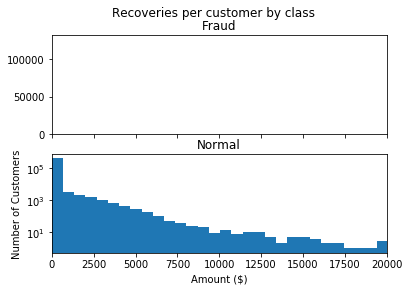

In [309]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Recoveries per customer by class')
bins = 50
ax1.hist(Fraud.recoveries, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.recoveries, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Customers')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

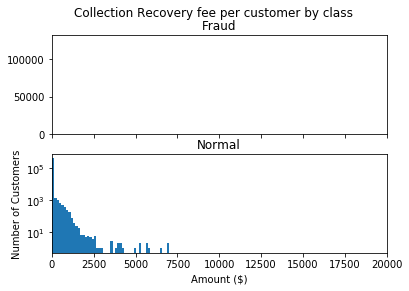

In [310]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Collection Recovery fee per customer by class')
bins = 50
ax1.hist(Fraud.collection_recovery_fee, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.collection_recovery_fee, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Customers')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

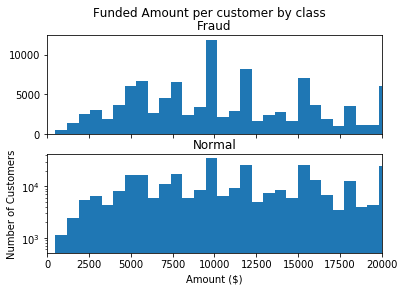

In [395]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Funded Amount per customer by class')
bins = 50
ax1.hist(Fraud.funded_amnt, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.funded_amnt, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Customers')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

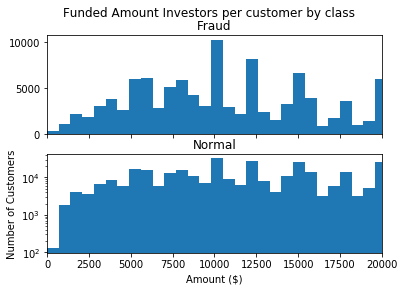

In [396]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Funded Amount Investors per customer by class')
bins = 50
ax1.hist(Fraud.funded_amnt_inv, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.funded_amnt_inv, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Customers')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

C:\Users\HA163WN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\HA163WN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


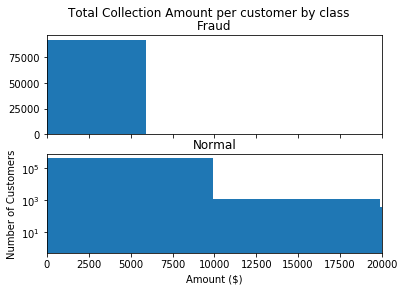

In [397]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Total Collection Amount per customer by class')
bins = 50
ax1.hist(Fraud.tot_coll_amt, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.tot_coll_amt, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Customers')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

# Missing value Treatment

In [314]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 *mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    return mis_val_table_ren_columns

In [315]:
missing_values_table(data)

,Missing Values,% of Total Values
verification_status_joint,532123,99.9
desc,456829,85.8
mths_since_last_record,450305,84.6
mths_since_last_major_derog,399448,75.0
mths_since_last_delinq,272554,51.2
batch_enrolled,85149,16.0
tot_cur_bal,42004,7.9
tot_coll_amt,42004,7.9
total_rev_hi_lim,42004,7.9
emp_title,30833,5.8


In [316]:
# Dropped columns where missing values are too high
modDf= data.drop(['verification_status_joint','desc','mths_since_last_record','batch_enrolled','title','mths_since_last_major_derog'], axis=1)

In [317]:
missing_values_table(modDf)

,Missing Values,% of Total Values
mths_since_last_delinq,272554,51.2
tot_coll_amt,42004,7.9
tot_cur_bal,42004,7.9
total_rev_hi_lim,42004,7.9
emp_title,30833,5.8
emp_length,26891,5.1
revol_util,287,0.1
collections_12_mths_ex_med,95,0.0
delinq_2yrs,16,0.0
inq_last_6mths,16,0.0


The missing values for mths_since_last_delinq is also quite high, but I retained it since I consider it a important variable. The missing values are replaced by zero. Other operations, such as mean/median could be used for this treatment. 

In [318]:
modDf = modDf.fillna(0)

In [319]:
# Get names of indexes for which annual income is zero
indexNames = modDf[ modDf['annual_inc'] == 0 ].index

# Delete these row indexes from dataFrame
modDf.drop(indexNames , inplace=True)

In [320]:
missing_values_table(modDf)

,Missing Values,% of Total Values


# Feature Engineering

New features are being created out of the exisitng features, for better predictive modelling

In [321]:
modDf['diff_funded_amnt_annualincome'] = (modDf['funded_amnt'] - modDf['annual_inc'])

In [323]:
Fraud_1 = modDf[modDf['loan_status']==1]

Normal_1 = modDf[modDf['loan_status']==0]

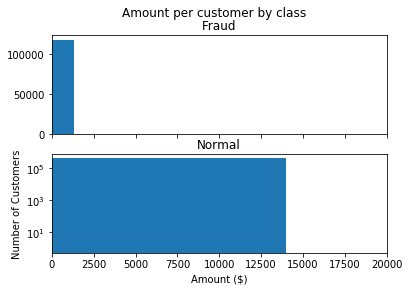

In [324]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per customer by class')
bins = 50
ax1.hist(Fraud_1.diff_funded_amnt_annualincome, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal_1.diff_funded_amnt_annualincome, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Customers')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

In [326]:
modDf['sum'] = modDf.loc[:,['funded_amnt','funded_amnt_inv']].sum(axis=1)

In [327]:
modDf['ratio'] = modDf['funded_amnt']/modDf['sum']

# Dummy variables
The categorical variables need to be converted to numerical variables so that we can feed the numerical data to our Machine Learning Algorithms. 

In [337]:
modDf_merged=pd.get_dummies(modDf[['term','grade','sub_grade','emp_length','verification_status','pymnt_plan','purpose','initial_list_status','application_type']])

In [338]:
modDf_merged

,term_36 months,term_60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532423,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
532424,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
532425,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
532426,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [340]:
df_col_merged2=modDf.drop(['term','grade','sub_grade','emp_length','verification_status','pymnt_plan','purpose','initial_list_status','application_type'],axis=1)
modDf=pd.concat([df_col_merged2,modDf_merged],axis=1)

In [341]:
modDf

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_title,home_ownership,annual_inc,zip_code,addr_state,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT
0,58189336,14350,14350,14350.0,19.19,clerk,OWN,28700.0,349xx,FL,...,0,0,0,0,0,0,1,0,1,0
1,70011223,4800,4800,4800.0,10.99,Human Resources Specialist,MORTGAGE,65000.0,209xx,MD,...,0,0,0,0,0,0,0,1,1,0
2,70255675,10000,10000,10000.0,7.26,Driver,OWN,45000.0,447xx,OH,...,0,0,0,0,0,0,0,1,1,0
3,1893936,15000,15000,15000.0,19.72,Us office of Personnel Management,RENT,105000.0,221xx,VA,...,0,0,0,0,0,0,1,0,1,0
4,7652106,16000,16000,16000.0,10.64,LAUSD-HOLLYWOOD HIGH SCHOOL,RENT,52000.0,900xx,CA,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532423,31296187,20000,20000,20000.0,12.49,Registered Nurse,MORTGAGE,75000.0,481xx,MI,...,0,0,0,0,0,0,1,0,1,0
532424,29403184,12000,12000,12000.0,14.99,Account Mgr,MORTGAGE,59000.0,496xx,MI,...,0,0,0,0,0,0,0,1,1,0
532425,7357607,18725,18725,18725.0,20.80,Comcast cable,RENT,42504.0,370xx,TN,...,0,0,0,0,0,0,1,0,1,0
532426,23182668,21000,21000,21000.0,16.29,Resident Physician,RENT,50000.0,432xx,OH,...,0,0,0,0,0,0,0,1,1,0


# Data Cleaning
Some of the features(columns) need to be converted from strings to numerical value and feature names are also need to be changed specific for certain ML algorithms.

In [342]:
modDf= modDf.drop(['emp_title','addr_state','home_ownership'], axis=1)
modDf=modDf.rename(columns = {'emp_length_< 1 year':'emp_length_less_a_year'})
modDf['zip_code'] = modDf['zip_code'].str.replace('xx', '')
modDf['last_week_pay'] = modDf['last_week_pay'].str.replace('th week', '')
modDf['last_week_pay'] = modDf['last_week_pay'].str.replace('NA', '0')
modDf['last_week_pay'] = pd.to_numeric(modDf['last_week_pay'])
modDf['zip_code'] = pd.to_numeric(modDf['zip_code'])

# Data Balancing 
The predicition gives better results when the ratio of fraud v/s non fraud is close. Since, we have a large dataset, I considered reducing the number of non-fraud to make it colse to the fraud data.

In [350]:
modDf = modDf.drop(modDf[modDf['loan_status'] == 0].sample(frac=0.69).index)

In [351]:
print(modDf.groupby('loan_status').size())

loan_status
0    126046
1    125824
dtype: int64


# Correlation Matrix
The correlation between target variable and different features are seen. It gives us an idea, which variables might contribute to our model predictions. Please ignore member_id.

In [352]:
corr_matrix = modDf.corr().abs()

print(corr_matrix['loan_status'].sort_values(ascending=False).head(10))

loan_status              1.000000
member_id                0.580329
last_week_pay            0.291549
initial_list_status_w    0.274005
initial_list_status_f    0.274005
dti                      0.162718
term_60 months           0.160487
term_36 months           0.160487
total_rev_hi_lim         0.124994
funded_amnt_inv          0.120159
Name: loan_status, dtype: float64


The correlation matrix shows us although their is correlation between variables,but amount of correlation is not too high. So, features could be retained, otherwise highly correlated features might result in over-fitting.

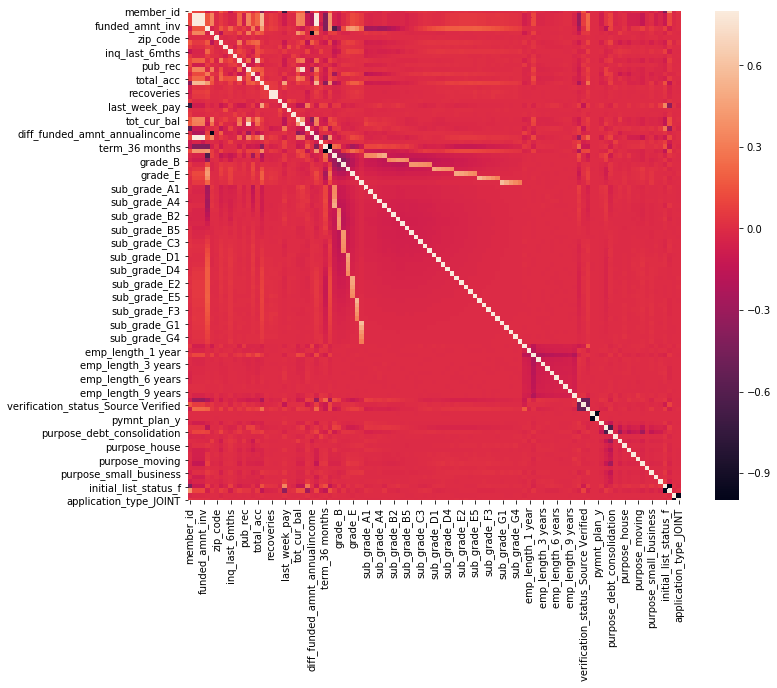

In [353]:
correlation_matrix = modDf.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

# Data Preparation for Modelling
The data to be fed into the model requires us to seperate between target variable and independent variables.

In [354]:
x = modDf.drop(['member_id','loan_status'], axis=1)
y = modDf['loan_status']

In [355]:
x

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,annual_inc,zip_code,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT
0,14350,14350,14350.0,19.19,28700.0,349,33.88,0.0,1.0,50.0,...,0,0,0,0,0,0,1,0,1,0
2,10000,10000,10000.0,7.26,45000.0,447,18.42,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
3,15000,15000,15000.0,19.72,105000.0,221,14.97,0.0,2.0,46.0,...,0,0,0,0,0,0,1,0,1,0
4,16000,16000,16000.0,10.64,52000.0,900,20.16,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
5,15000,15000,14950.0,8.90,120000.0,461,12.30,0.0,0.0,56.0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532418,10000,10000,10000.0,9.76,54000.0,840,25.07,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
532420,5700,5700,5700.0,14.16,37000.0,178,25.36,0.0,3.0,49.0,...,0,0,0,0,0,0,1,0,1,0
532422,10000,10000,10000.0,14.33,49900.0,984,20.20,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,1,0
532423,20000,20000,20000.0,12.49,75000.0,481,14.53,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0


# Outlier Treatment
For, this we need to first see if there are outliers in our sample, but I have directly capped my independent variables between 1 percentile and 99 percentile, whic means any value larger than 99 percentile would be capped as 99 percentile and smaller than 1 percentile will be replaced be 1 percentile value. Thee purpose is to prevent skewness of the model caused by few values.

In [356]:
for col in x.columns:
    percentiles = x[col].quantile([0.01,0.99]).values
    x[col] = np.clip(x[col], percentiles[0], percentiles[1])

# Train test split
The data needs to be further split into training and testing so that we can measure our model performance before working on the hold out sample. Here, 30 percent data is marked for testing.

In [358]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(x, y, test_size=0.3, random_state=2)

In [359]:
print(trainX.shape)
print(testX.shape)
print(trainy.shape)
print(testy.shape)

(176309, 107)
(75561, 107)
(176309,)
(75561,)


# Model Predictions
After anlalysing, cleaning and preparing the data, predictive modelling is used to train our dataset and predict fraud in test data. For modelling, I have used XGBoost and Random Forest. Also, I have tried Logistic Regression, but since the results were not as comparable to other two I have dropped it from my notebook. As, required for this exercise I have used AUC to evaulate my model performance on test data. AUC used predicted probabilities along with target variables for evaluation.  

# XGBoost

XGBoost: f1=0.727 auc=0.848


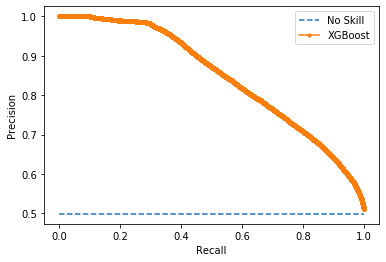

In [360]:
# fit a model

model = XGBClassifier()

model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Random Forest

RandomForest: f1=0.727 auc=0.847


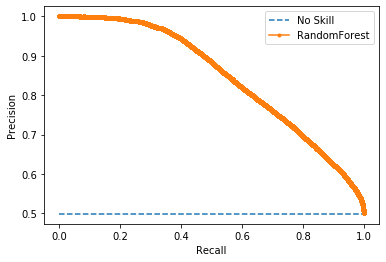

In [362]:
# fit a model
#model = LogisticRegression(solver='lbfgs')
model1  = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=100,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=42,
                      max_features='auto')

model1.fit(trainX, trainy)
# predict probabilities
lr_probs1 = model1.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs1 = lr_probs1[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs1)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('RandomForest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='RandomForest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [363]:
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=100,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=42,
                      max_features='auto')

In [364]:
clf=rf_classifier.fit(trainX,trainy)


# Feature Importance
To understand, which features are important/played a vital role for our predictions, I have graphically represented top 12 features.

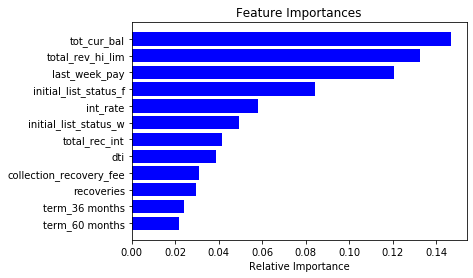

In [366]:
features = trainX.columns
importances =clf.feature_importances_
indices = np.argsort(importances)[-12:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [367]:
# Print the name and gini importance of each feature
for feature in zip(data, clf.feature_importances_):
    print(feature)

('member_id', 0.009937071415871673)
('loan_amnt', 0.010346086870695232)
('funded_amnt', 0.013916913293442003)
('funded_amnt_inv', 0.057814130451459826)
('term', 0.01059844417490927)
('batch_enrolled', 0.009744148673493337)
('int_rate', 0.03878406848297387)
('grade', 0.002016152297483638)
('sub_grade', 0.010276388355147872)
('emp_title', 0.0055897472077772225)
('emp_length', 0.006197784238987922)
('home_ownership', 0.0019806205265034357)
('annual_inc', 0.010647206649472338)
('verification_status', 0.013920332833535418)
('pymnt_plan', 0.01150189283691968)
('desc', 0.04163806537183243)
('purpose', 0.000403716119575764)
('title', 0.029420805067048937)
('zip_code', 0.030741676145003102)
('addr_state', 0.000405454332826081)
('dti', 0.12032467781814161)
('delinq_2yrs', 0.0)
('inq_last_6mths', 0.006088540415506699)
('mths_since_last_delinq', 0.14657128055870158)
('mths_since_last_record', 0.13247219991144155)
('open_acc', 0.01247725912379364)
('pub_rec', 0.011938443772123808)
('revol_bal', 0.0

# Reading the data(Test)

In [368]:
test = pd.read_csv('test_indessa.csv')

In [370]:
test.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,...,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,11937648,14000,14000,14000.0,60 months,BAT4711174,16.24,C,C5,Data Analyst,...,0.0,0.0,NaN,INDIVIDUAL,NaN,104th week,0.0,0.0,85230.0,45700.0
1,38983318,16000,16000,16000.0,60 months,BAT4318899,9.49,B,B2,Senior Database Administrator,...,0.0,0.0,NaN,INDIVIDUAL,NaN,57th week,0.0,0.0,444991.0,21400.0
2,27999917,11050,11050,11050.0,60 months,BAT446479,15.61,D,D1,Customer service representative,...,0.0,0.0,26.0,INDIVIDUAL,NaN,70th week,0.0,0.0,105737.0,16300.0
3,61514932,35000,35000,34700.0,60 months,BAT4664105,12.69,C,C2,ACCT OFFICER,...,0.0,0.0,NaN,INDIVIDUAL,NaN,22th week,0.0,0.0,287022.0,72400.0
4,59622821,6500,6500,6500.0,36 months,,6.89,A,A3,Paralegal,...,0.0,0.0,NaN,INDIVIDUAL,NaN,22th week,0.0,0.0,234278.0,26700.0


# Missing value Treatment

In [371]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 *mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    return mis_val_table_ren_columns

In [372]:
missing_values_table(test)

,Missing Values,% of Total Values
verification_status_joint,354745,99.9
desc,304770,85.9
mths_since_last_record,300021,84.5
mths_since_last_major_derog,266228,75.0
mths_since_last_delinq,181758,51.2
batch_enrolled,45599,12.8
tot_cur_bal,28272,8.0
tot_coll_amt,28272,8.0
total_rev_hi_lim,28272,8.0
emp_title,20629,5.8


In [373]:
mod_test= test.drop(['verification_status_joint','desc','mths_since_last_record','batch_enrolled','title','mths_since_last_major_derog'], axis=1)

In [374]:
missing_values_table(mod_test)

,Missing Values,% of Total Values
mths_since_last_delinq,181758,51.2
tot_coll_amt,28272,8.0
tot_cur_bal,28272,8.0
total_rev_hi_lim,28272,8.0
emp_title,20629,5.8
emp_length,17934,5.1
revol_util,215,0.1
collections_12_mths_ex_med,50,0.0
delinq_2yrs,13,0.0
inq_last_6mths,13,0.0


In [375]:
mod_test = mod_test.fillna(0)

In [377]:
mod_test= mod_test.drop(['emp_title','addr_state','home_ownership'], axis=1)

# Dummy Variables

In [378]:
mod_test_merged=pd.get_dummies(mod_test[['term','grade','sub_grade','emp_length','verification_status','pymnt_plan','purpose','initial_list_status','application_type']])

In [379]:
mod_test_merged

,term_36 months,term_60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354946,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
354947,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
354948,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
354949,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [381]:
mod_test_merged2=mod_test.drop(['term','grade','sub_grade','emp_length','verification_status','pymnt_plan','purpose','initial_list_status','application_type'],axis=1)
mod_test=pd.concat([mod_test_merged,mod_test_merged2],axis=1)

In [382]:
mod_test

,term_36 months,term_60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0,1,0,0,1,0,0,0,0,0,...,3915.61,0.0,0.0,0.0,0.0,104th week,0.0,0.0,85230.0,45700.0
1,0,1,0,1,0,0,0,0,0,0,...,1495.06,0.0,0.0,0.0,0.0,57th week,0.0,0.0,444991.0,21400.0
2,0,1,0,0,0,1,0,0,0,0,...,2096.21,0.0,0.0,0.0,0.0,70th week,0.0,0.0,105737.0,16300.0
3,0,1,0,0,1,0,0,0,0,0,...,1756.31,0.0,0.0,0.0,0.0,22th week,0.0,0.0,287022.0,72400.0
4,1,0,1,0,0,0,0,0,0,0,...,172.21,0.0,0.0,0.0,0.0,22th week,0.0,0.0,234278.0,26700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354946,1,0,1,0,0,0,0,0,0,0,...,1180.32,0.0,0.0,0.0,0.0,83th week,0.0,0.0,143920.0,44000.0
354947,0,1,0,0,0,0,0,0,1,0,...,6508.41,0.0,0.0,0.0,0.0,39th week,0.0,0.0,772713.0,85700.0
354948,0,1,0,0,0,0,1,0,0,0,...,3456.24,0.0,0.0,0.0,0.0,87th week,0.0,0.0,0.0,0.0
354949,1,0,1,0,0,0,0,0,0,0,...,766.84,0.0,0.0,0.0,0.0,35th week,0.0,0.0,291998.0,54600.0


# Data Cleaning

In [383]:
mod_test=mod_test.rename(columns = {'emp_length_< 1 year':'emp_length_less_a_year'})
mod_test['zip_code'] = mod_test['zip_code'].str.replace('xx', '')
mod_test=mod_test.rename(columns = {'emp_length_< 1 year':'emp_length_less_a_year'})
mod_test['zip_code'] = mod_test['zip_code'].str.replace('xx', '')
mod_test['last_week_pay'] = mod_test['last_week_pay'].str.replace('th week', '')
mod_test['last_week_pay'] = mod_test['last_week_pay'].str.replace('NA', '0')
mod_test['last_week_pay'] = pd.to_numeric(mod_test['last_week_pay'])
mod_test['zip_code'] = pd.to_numeric(mod_test['zip_code'])

In [384]:
mod_test

,term_36 months,term_60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0,1,0,0,1,0,0,0,0,0,...,3915.61,0.0,0.0,0.0,0.0,104,0.0,0.0,85230.0,45700.0
1,0,1,0,1,0,0,0,0,0,0,...,1495.06,0.0,0.0,0.0,0.0,57,0.0,0.0,444991.0,21400.0
2,0,1,0,0,0,1,0,0,0,0,...,2096.21,0.0,0.0,0.0,0.0,70,0.0,0.0,105737.0,16300.0
3,0,1,0,0,1,0,0,0,0,0,...,1756.31,0.0,0.0,0.0,0.0,22,0.0,0.0,287022.0,72400.0
4,1,0,1,0,0,0,0,0,0,0,...,172.21,0.0,0.0,0.0,0.0,22,0.0,0.0,234278.0,26700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354946,1,0,1,0,0,0,0,0,0,0,...,1180.32,0.0,0.0,0.0,0.0,83,0.0,0.0,143920.0,44000.0
354947,0,1,0,0,0,0,0,0,1,0,...,6508.41,0.0,0.0,0.0,0.0,39,0.0,0.0,772713.0,85700.0
354948,0,1,0,0,0,0,1,0,0,0,...,3456.24,0.0,0.0,0.0,0.0,87,0.0,0.0,0.0,0.0
354949,1,0,1,0,0,0,0,0,0,0,...,766.84,0.0,0.0,0.0,0.0,35,0.0,0.0,291998.0,54600.0


# Feature Engineering

In [385]:

mod_test['diff_funded_amnt_annualincome'] = (mod_test['funded_amnt'] - mod_test['annual_inc'])
mod_test['sum'] = mod_test.loc[:,['funded_amnt','funded_amnt_inv']].sum(axis=1)
mod_test['ratio'] = mod_test['funded_amnt']/mod_test['sum']

In [387]:
x1 = mod_test.drop(['member_id'], axis=1)

In [388]:
for col in x1.columns:
    percentiles = x1[col].quantile([0.01,0.99]).values
    x[col] = np.clip(x1[col], percentiles[0], percentiles[1])

In [389]:
x1

,term_36 months,term_60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,...,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,diff_funded_amnt_annualincome,sum,ratio
0,0,1,0,0,1,0,0,0,0,0,...,0.0,0.0,104,0.0,0.0,85230.0,45700.0,-59500.0,28000.0,0.500000
1,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,57,0.0,0.0,444991.0,21400.0,-89000.0,32000.0,0.500000
2,0,1,0,0,0,1,0,0,0,0,...,0.0,0.0,70,0.0,0.0,105737.0,16300.0,-51250.0,22100.0,0.500000
3,0,1,0,0,1,0,0,0,0,0,...,0.0,0.0,22,0.0,0.0,287022.0,72400.0,-115000.0,69700.0,0.502152
4,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,22,0.0,0.0,234278.0,26700.0,-45500.0,13000.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354946,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,83,0.0,0.0,143920.0,44000.0,-82250.0,30000.0,0.500000
354947,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,39,0.0,0.0,772713.0,85700.0,-145000.0,70000.0,0.500000
354948,0,1,0,0,0,0,1,0,0,0,...,0.0,0.0,87,0.0,0.0,0.0,0.0,-42000.0,27975.0,0.500447
354949,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,35,0.0,0.0,291998.0,54600.0,-80000.0,40000.0,0.500000


# Predicted Probabilites(Random Forest)

In [390]:

lr_probs = clf.predict_proba(x1)[:, 1]

# Feature Importance

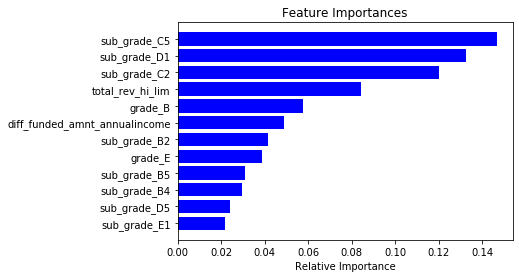

In [392]:
features = x1.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[-12:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [393]:
dd = pd.DataFrame(lr_probs)

In [394]:
dd

,0
0,0.882506
1,0.901350
2,0.890126
3,0.881318
4,0.881417
...,...
354946,0.878611
354947,0.875241
354948,0.703683
354949,0.879945


In [400]:
dd.to_csv('submission_Joseph.csv')

In [398]:
submission = pd.read_csv('sample_submission.csv')

In [399]:
submission

,member_id,loan_status
0,11937648,0.5
1,38983318,0.5
2,27999917,0.5
3,61514932,0.5
4,59622821,0.5
...,...,...
95,65591455,0.5
96,10417131,0.5
97,62958047,0.5
98,15950344,0.5


# Conclusion
This exercise would provide the predicted fraud probabilities for Bank Indessa. Although, I have tried to create some features, out of the given features but with more feature engineering the AUC would get better. 